In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t

# Data Preprocessing

In [2]:
warnings.filterwarnings("ignore")
df1 = pd.read_csv("world-university-rankings_timesData.csv")

In [3]:
df1['female_ratio'] = df1['female_male_ratio'].str.split(':').str[0]
df1['male_ratio'] = df1['female_male_ratio'].str.split(':').str[1]
df1 = df1.drop('female_male_ratio',axis=1)
df1['female_ratio'] = df1['female_ratio'].replace('-', 0)
df1['female_ratio'] = df1['female_ratio'].astype(float)
df1['male_ratio'] = df1['male_ratio'].astype(float)
df1['female_ratio'] = df1['female_ratio']/100
df1['male_ratio'] = df1['male_ratio']/100


In [4]:
df1['num_students'] = df1['num_students'].str.replace(',','')
df1['num_students'] = df1['num_students'].astype(float)
df1['international_students'] = df1['international_students'].str.replace('%','')
df1['international_students'] = df1['international_students'].astype(float)/100
df1['total_score'] = df1['total_score'].str.replace('-','0')
df1['total_score'] = df1['total_score'].astype(float)

In [5]:
df1['income'] = df1['income'].str.replace('-','0')
df1['income'] = df1['income'].astype(float)
df1['country'] = df1['country'].str.replace('Unted Kingdom','United Kingdom')
df1.fillna(0, inplace=True)

In [6]:
df1.head()

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,year,female_ratio,male_ratio
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152.0,8.9,0.25,2011,0.00,0.00
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,2243.0,6.9,0.27,2011,0.33,0.67
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,11074.0,9.0,0.33,2011,0.37,0.63
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,15596.0,7.8,0.22,2011,0.42,0.58
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,0.0,94.2,7929.0,8.4,0.27,2011,0.45,0.55


In [7]:
df1.to_csv('clean_timesData.csv')

# Data Visualization

## Plot 1: Bar plot - top 10 countries with the highest university average total score

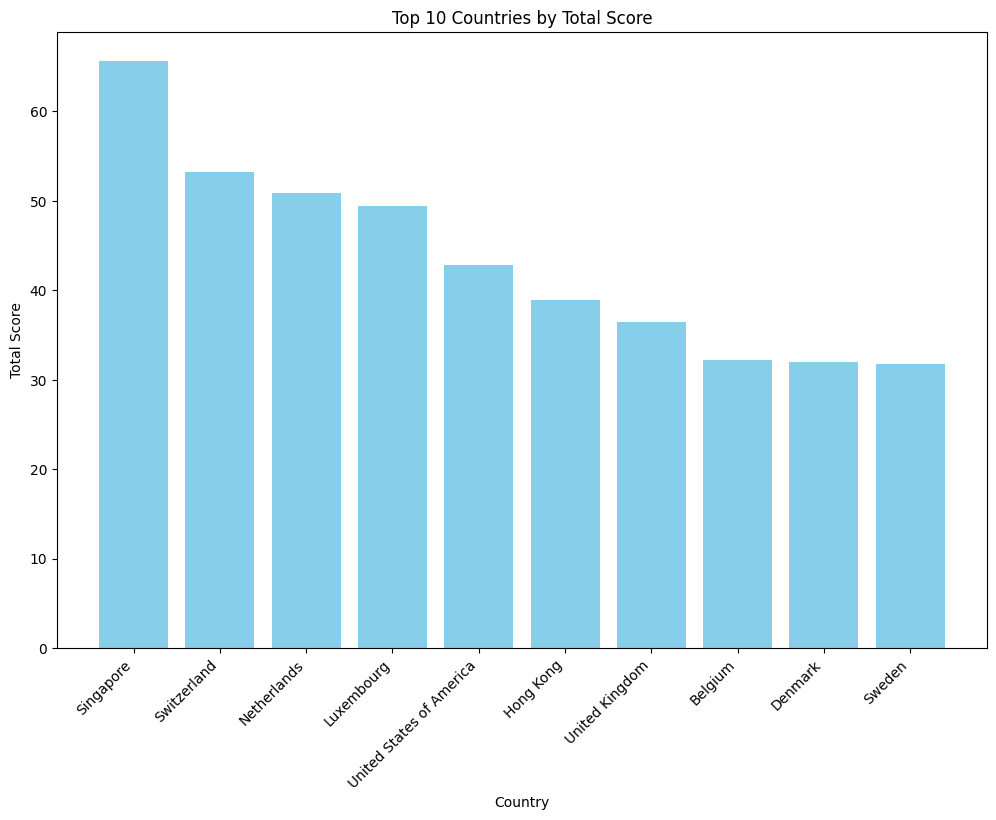

In [8]:
def top_university_ranks(df):
    df_copy = df.copy()
    df_copy = df_copy.groupby('country')['total_score'].mean().reset_index()
    df_sorted = df_copy.sort_values(by='total_score', ascending=False)
    top_10_countries = df_sorted.head(10)
    #print(top_10_countries)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(top_10_countries['country'], top_10_countries['total_score'], color='skyblue')
    ax.set_xlabel('Country')
    ax.set_ylabel('Total Score')
    ax.set_title('Top 10 Countries by Total Score')
    ax.set_xticklabels(top_10_countries['country'], rotation=45, ha='right')
    plt.show()
top_university_ranks(df1)

explaination:   
Countries with better economies can have higher average university scores.

---

## Plot2: Correlations between columns

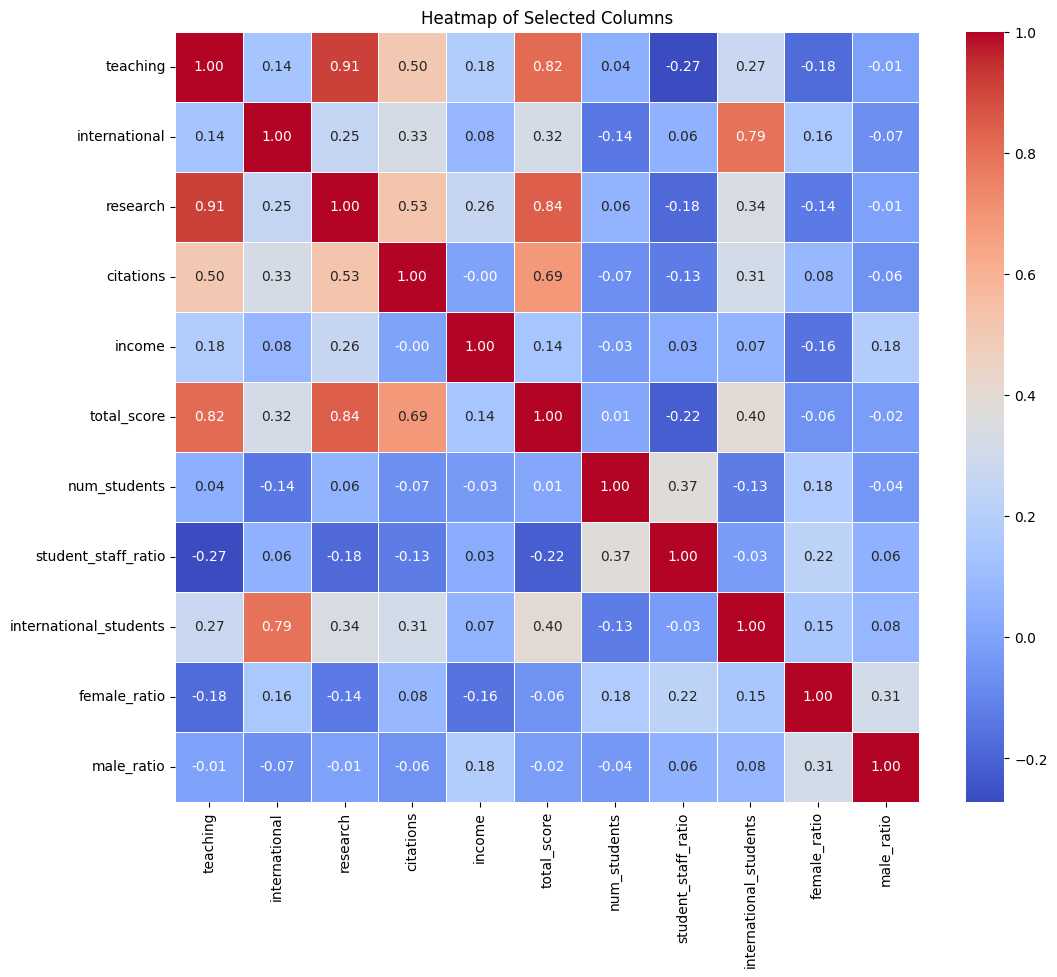

In [100]:
def plot_correlations(df):
    df_copy = df.copy()
    df_copy.replace('-', pd.NA, inplace=True)
    df_copy = df_copy.dropna()
    selected_columns = ['teaching', 'international', 'research', 'citations',
                    'income', 'total_score', 'num_students', 'student_staff_ratio',
                    'international_students', 'female_ratio', 'male_ratio']
    df_selected = df_copy[selected_columns]
    correlation_matrix = df_selected.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Heatmap of Selected Columns')
    plt.show()
plot_correlations(df1)

explaination:   
research, teaching and citation have strong correlation between each other.  
  
the teaching level effect the total score of a university a lot.  
  
male/female ratio is not strongly correlated with other columns, that is, gender does not affect academic standards or the reputation of the school.  

---

## Plot3: 3D plots of three strongly correlated features

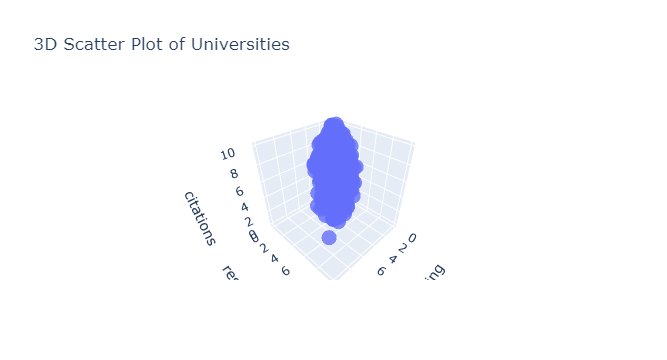

In [101]:
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

def plot_3d_unis(df):
    features = df[['teaching', 'research', 'citations']]
    scaler = MinMaxScaler(feature_range=(0, 10))
    scaled_features = scaler.fit_transform(features)
    df_scaled = pd.DataFrame(scaled_features, columns=['teaching', 'research', 'citations'])
    fig = px.scatter_3d(df_scaled, x='teaching', y='research', z='citations',
                        opacity=0.8, size_max=10,
                        title='3D Scatter Plot of Universities', labels={'cluster': 'Cluster'})
    fig.show()
plot_3d_unis(df1)

explaination:  
from the correlation heat map we know that teaching, citation and research is strongly correlated but is it all the secret between them?  
  
We can see the pairwise relationship between these three features by dragging the 3d plot:  
  
there is university with low research level and high citation level, but there is no university with high research level and low citation level(nice papers must be cited!)  
  
there is no university with high teaching standard and low citation level(It seems that students' independent learning can achieve some success in a paper with recognition, but with the support of high-quality teaching, it is almost inevitable to produce paper with high quality)  

research and teaching is highly correlated and there is almost no exceptions!  

---

## Plot 4 Bar Plot - The numebr of The Top 100 universities per Year in each Country

In [102]:
count_df = df1[~df1['world_rank'].str.contains('-')]
count_df['world_rank'] = count_df['world_rank'].str.replace('=','')
count_df['world_rank'] = count_df['world_rank'].astype(int)
count_df = count_df[count_df['world_rank'] <= 100]
count_df = count_df.groupby(['year','country']).size().reset_index(name='count')

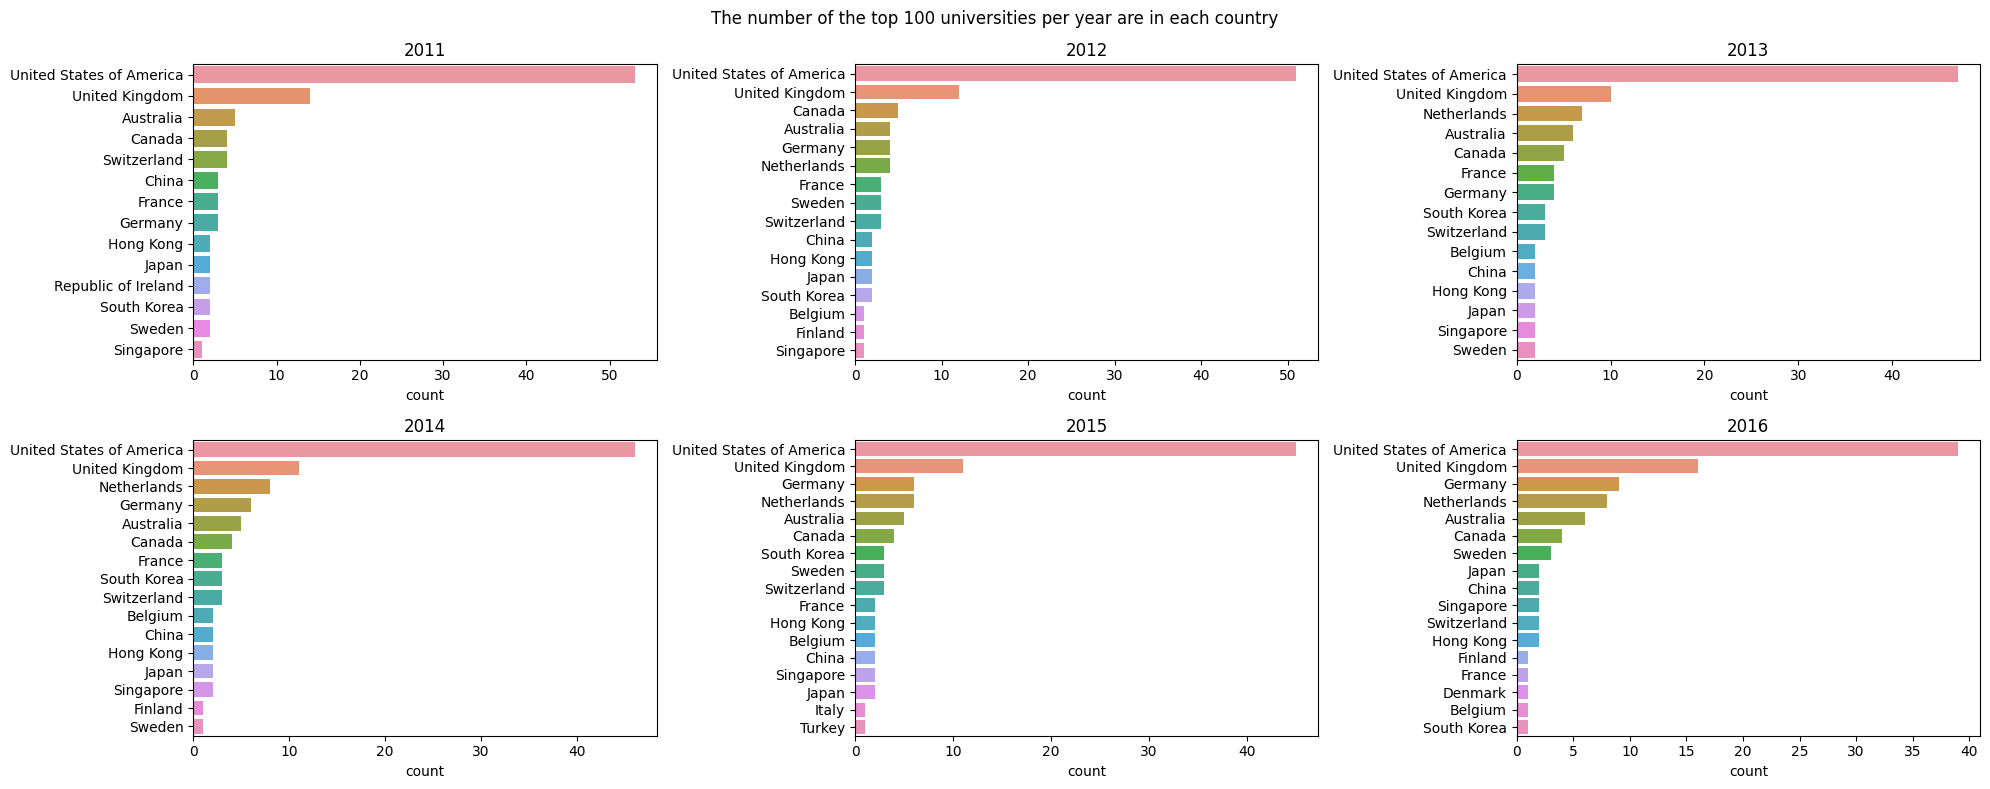

In [103]:
df_11 = count_df[count_df['year'] == 2011]
df_12 = count_df[count_df['year'] == 2012]
df_13 = count_df[count_df['year'] == 2013]
df_14 = count_df[count_df['year'] == 2014]
df_15 = count_df[count_df['year'] == 2015]
df_16 = count_df[count_df['year'] == 2016]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
plt.suptitle("The number of the top 100 universities per year are in each country")

sns.barplot(x = 'count',y = 'country', data = df_11, ax = axes[0,0], order=df_11.sort_values('count', ascending=False)['country'])
axes[0,0].set_title('2011')
axes[0,0].set_ylabel('')

sns.barplot(x = 'count',y = 'country', data = df_12, ax = axes[0,1], order=df_12.sort_values('count', ascending=False)['country'])
axes[0,1].set_title('2012')
axes[0,1].set_ylabel('')

sns.barplot(x = 'count',y = 'country', data = df_13, ax = axes[0,2],order=df_13.sort_values('count', ascending=False)['country'])
axes[0,2].set_title('2013')
axes[0,2].set_ylabel('')

sns.barplot(x = 'count',y = 'country', data = df_14, ax = axes[1,0],order=df_14.sort_values('count', ascending=False)['country'])
axes[1,0].set_title('2014')
axes[1,0].set_ylabel('')

sns.barplot(x = 'count',y = 'country', data = df_15, ax = axes[1,1],order=df_15.sort_values('count', ascending=False)['country'])
axes[1,1].set_title('2015')
axes[1,1].set_ylabel('')

sns.barplot(x = 'count',y = 'country', data = df_16, ax = axes[1,2],order=df_16.sort_values('count', ascending=False)['country'])
axes[1,2].set_title('2016')
axes[1,2].set_ylabel('')

plt.tight_layout()
plt.show()

Explaination:

We counted how many univerisities entered the Top 100 in each country each year between 2011 to 2016. We find the both the US and the UK rank in the top two of the Top 100 universities in terms of volumne. Australia, Canda, Netherlands, Germany are also ranked high in terms of the number of Top 100 universities per year.

---

## Plot 5 - Line bar - The Proportion of International Students In Austrialia, Canada, France, Germany, United Kingdom, United States of America

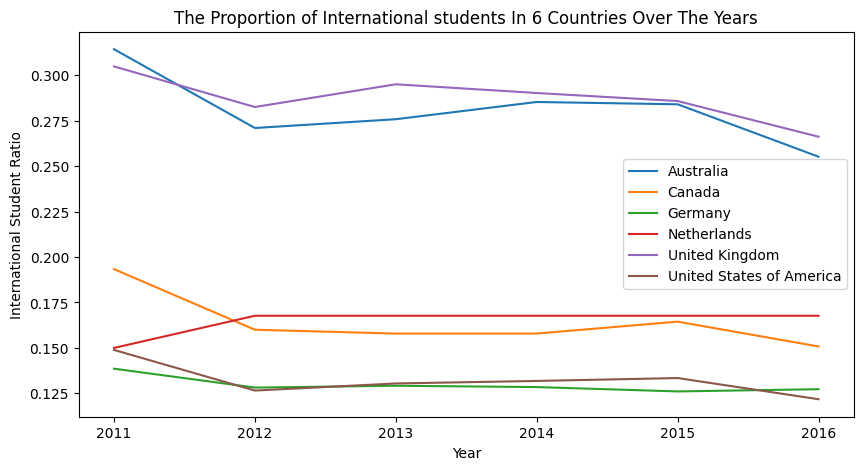

In [9]:
intStu_df = df1[['university_name','country','international_students','year']]
temp = intStu_df.groupby(['country','year'])['international_students'].mean().reset_index()

sort_df = temp[(temp['country'] == 'Australia') | (temp['country'] == 'Canada')
               |(temp['country'] == 'United Kingdom') | (temp['country'] == 'United States of America')
               | (temp['country'] == 'Netherlands')|(temp['country'] == 'Germany')]

plt.figure(figsize=(10,5))
sns.lineplot(x = 'year', y = 'international_students', data = sort_df, hue = 'country')
plt.xlabel('Year')
plt.ylabel('International Student Ratio')
plt.title("The Proportion of International students In 6 Countries Over The Years")
plt.legend(loc='right')
plt.show()

Explaination:

We find that the proportion of international students enrolled in universities in Australia and the United Kingdom is greater than in France, U.S., and Germany. Regardless of the country, there is a downward trend in the proportion of international students enrolled year after year.

---

## Plot 6 - Line Plot - Total number of small and large classes at top 10 universities vs. total number of small and large classes at rank 90-100

Text(0.5, 1.0, 'Universities Ranked Between 90 and 100')

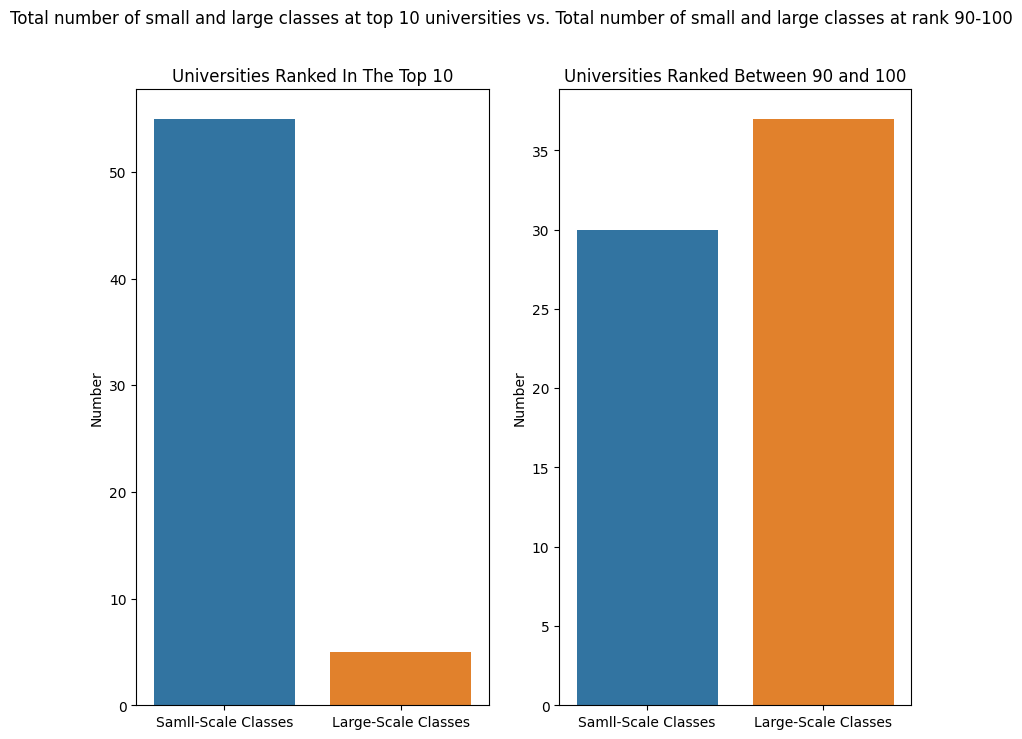

In [10]:
c_df = df1
c_df = df1[~df1['world_rank'].str.contains('-')]
c_df['world_rank'] = c_df['world_rank'].str.replace('=','')
c_df['world_rank'] = c_df['world_rank'].astype(int)
c_df = c_df[c_df['world_rank'] <= 100]
Top10_df = c_df[c_df['world_rank'] <= 10]
low90_df = c_df[c_df['world_rank'] >= 90]

n1 = len(Top10_df[Top10_df['student_staff_ratio'] < 15.0])
n2 = len(Top10_df[Top10_df['student_staff_ratio'] >= 15.0])
n3 = len(low90_df[low90_df['student_staff_ratio'] < 15.0])
n4 = len(low90_df[low90_df['student_staff_ratio'] >= 15.0])

top10 = [n1, n2]
rank90 = [n3,n4]
category = ['Samll-Scale Classes', 'Large-Scale Classes']

c_df = pd.DataFrame({'top10': top10, 'rank90': rank90, 'Category': category})
c_df

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
plt.suptitle("Total number of small and large classes at top 10 universities vs. Total number of small and large classes at rank 90-100")
sns.barplot(x='Category', y='top10', data=c_df, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Number')
axes[0].set_title("Universities Ranked In The Top 10")
sns.barplot(x='Category', y='rank90', data=c_df, ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Number')
axes[1].set_title("Universities Ranked Between 90 and 100")

Explaination:

The total number of small classes at the top 10 univerisities is greater than at univerisities is ranked between 90 to 100, while the total number of large classes at the top 10 universities is much lower than at universities ranked between 90 to 100. This may indicate that th equality of small class teaching is better than that of large class teaching. 

---

# Hypothesis Testing

## hypothesis1: one tailed research:

$$μ_{\text{America_2015}} : \text{mean of research score in America 2014}$$
$$μ_{\text{America_2015}} : \text{mean of research score in America 2014}$$

$$H_0: μ_{\text{America_2015}} ≤ μ_{\text{America_2014}}$$

$$H_1: μ_{\text{America_2015}} > μ_{\text{America_2014}}$$

**Null Hypothesis (H0):** The mean research score of American universities in a 2015 is less than or equal to the mean research score in the 2014.

**Alternative Hypothesis (H1):** The mean research score of universities in a 2015 is greater than the mean research score in the 2014.

In [106]:
df1['country'].unique()

array(['United States of America', 'United Kingdom', 'Switzerland',
       'Canada', 'Hong Kong', 'Japan', 'South Korea', 'Singapore',
       'Australia', 'China', 'France', 'Sweden', 'Germany',
       'Republic of Ireland', 'Finland', 'Taiwan', 'South Africa',
       'Turkey', 'Netherlands', 'Belgium', 'Denmark', 'Norway', 'Spain',
       'New Zealand', 'Egypt', 'Austria', 'Israel', 'Brazil', 'Italy',
       'Russian Federation', 'Greece', 'Iceland', 'Czech Republic',
       'India', 'Poland', 'Iran', 'Portugal', 'Thailand', 'Chile',
       'Estonia', 'Saudi Arabia', 'Mexico', 'Colombia', 'Macau',
       'Morocco', 'Luxembourg', 'Unisted States of America', 'Cyprus',
       'Uganda', 'Malaysia', 'Lebanon', 'Romania', 'Slovenia', 'Pakistan',
       'Hungary', 'United Arab Emirates', 'Belarus', 'Serbia', 'Slovakia',
       'Bangladesh', 'Ghana', 'Nigeria', 'Indonesia', 'Jordan', 'Latvia',
       'Kenya', 'Argentina', 'Qatar', 'Oman', 'Ukraine', 'Lithuania'],
      dtype=object)

### using fomular

In [107]:
# Filter data for American universities and the years 2014 and 2015
american_universities_2014 = df1[(df1['country'] == 'United States of America') & (df1['year'] == 2014)]
american_universities_2015 = df1[(df1['country'] == 'United States of America') & (df1['year'] == 2015)]

# Extract research scores for the two years
research_scores_2014 = american_universities_2014['research'].values
research_scores_2015 = american_universities_2015['research'].values

# Perform one-tailed t-test
# Calculate means
mean_2014 = sum(research_scores_2014) / len(research_scores_2014)
mean_2015 = sum(research_scores_2015) / len(research_scores_2015)

# Calculate standard deviations
std_2014 = (sum((x - mean_2014) ** 2 for x in research_scores_2014) / len(research_scores_2014)) ** 0.5
std_2015 = (sum((x - mean_2015) ** 2 for x in research_scores_2015) / len(research_scores_2015)) ** 0.5

# Calculate t-statistic
t_statistic = (mean_2015 - mean_2014) / ((std_2014 ** 2 / len(research_scores_2014)) + (std_2015 ** 2 / len(research_scores_2015))) ** 0.5

# Degrees of freedom
df = len(research_scores_2014) + len(research_scores_2015) - 2

# Set the significance level
alpha = 0.05

p_value = 1 - t.cdf(t_statistic, df)

# Print the results
print(f'Test Statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis. There is evidence to support the alternative hypothesis.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to support the alternative hypothesis.")

Test Statistic: 0.3576726890936268
P-value: 0.3604695728934395
Fail to reject the null hypothesis. There is not enough evidence to support the alternative hypothesis.


### Using inbuilt function

In [108]:
# Assuming df1 is your DataFrame
# Filter data for American universities and the years 2014 and 2015
american_universities_2014 = df1[(df1['country'] == 'United States of America') & (df1['year'] == 2014)]
american_universities_2015 = df1[(df1['country'] == 'United States of America') & (df1['year'] == 2015)]

# Extract research scores for the two years
research_scores_2014 = american_universities_2014['research']
research_scores_2015 = american_universities_2015['research']

# Perform one-tailed t-test
t_statistic, p_value = ttest_ind(research_scores_2015, research_scores_2014, alternative='greater')

# Define the significance level
alpha = 0.05

# Print the results
print(f'Test Statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis. There is evidence to support the alternative hypothesis.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to support the alternative hypothesis")

Test Statistic: 0.3560019592143461
P-value: 0.3610940850618117
Fail to reject the null hypothesis. There is not enough evidence to support the alternative hypothesis


## Hypothesis2: score two sided test:

$$μ_{America} : \text{mean of score in America}$$
$$μ_{China} : \text{mean of score employment in China}$$

$$H_0: μ_{China} = μ_{America}$$

$$H_1: μ_{China} - μ_{America} \neq 0$$

**Null Hypothesis (H0):** There is no significant difference in the average score between universities in China and America.

**Alternative Hypothesis (H1):** There is a significant difference in the average score between universities in China and America.

In [109]:
display(df1.head())
df1 = df1[df1['year'] == 2015]
df1.rename(columns={'total_score': 'score'}, inplace=True)
df1['country'].unique()

,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,year,female_ratio,male_ratio
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,20152.0,8.9,0.25,2011,0.00,0.00
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,2243.0,6.9,0.27,2011,0.33,0.67
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,11074.0,9.0,0.33,2011,0.37,0.63
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,15596.0,7.8,0.22,2011,0.42,0.58
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,0.0,94.2,7929.0,8.4,0.27,2011,0.45,0.55


array(['United States of America', 'United Kingdom', 'Switzerland',
       'Canada', 'Japan', 'Singapore', 'Germany', 'Australia',
       'Hong Kong', 'Sweden', 'China', 'South Korea', 'Belgium', 'France',
       'Italy', 'Netherlands', 'Turkey', 'Finland', 'Denmark',
       'South Africa', 'Republic of Ireland', 'Taiwan', 'Spain',
       'New Zealand', 'Austria', 'Norway', 'Israel', 'Russian Federation',
       'Brazil', 'Chile', 'Iceland', 'Colombia', 'India', 'Macau',
       'Czech Republic', 'Iran', 'Greece', 'Morocco', 'Poland',
       'Thailand', 'Portugal'], dtype=object)

In [110]:
Hypothesis_df = df1[['country', 'score']].dropna()

#filter
A = Hypothesis_df[Hypothesis_df['country'] == 'United States of America']
C = Hypothesis_df[Hypothesis_df['country'] == 'China']

#True Population data
America_total_case = A['score']
China_total_case = C['score']

$$Zscore = \frac{(\bar{x_1}-\bar{x_2}) - (μ_1-μ_2)}{\sqrt{\frac{σ_1^2}{n} + \frac{σ_2^2}{m}}}$$

$$\bar{x_1}:\text{sample mean of country 1}$$
$$\bar{x_2}:\text{sample mean of country 2}$$
$$μ_1:\text{true mean of country 1}$$
$$μ_2:\text{true mean of country 2}$$
$$σ_1: \text{Standard deviation of Country 1}$$
$$σ_2: \text{Standard deviation of Country 2}$$

In [111]:
# Calculate means and standard deviations
mean_china = np.mean(China_total_case)
mean_america = np.mean(America_total_case)
std_china = np.std(China_total_case)
std_america = np.std(America_total_case)

# Calculate the z-statistic
num_china = len(China_total_case)
num_america = len(America_total_case)

# Null Hypothesis = mu_1-mu_2 = 0
# Hypothesized difference (under the null hypothesis)
D = 0

z_score = (abs(mean_america - mean_china) - D) / np.sqrt((std_america**2 / num_america) + (std_china**2 / num_china))

# Two-tailed p-value
p_value = 2 * (1 - norm.cdf(np.abs(z_score)))

# Set the significance level (alpha)
alpha = 0.05

# Print the results
print(f'Z-Score: {z_score}')
print(f'P-Value: {p_value}')

# Compare p-value to the significance level
if p_value < alpha:
    print('Reject the Null Hypothesis. There is a significant difference in the average score between universities in China and America.')
else:
    print('Fail to reject the Null Hypothesis. There is no significant difference in the average score between universities in China and America.')

Z-Score: 3.1493222820112576
P-Value: 0.0016364961093648933
Reject the Null Hypothesis. There is a significant difference in the average score between universities in China and America.
